- <a href='#1'>1. Cargar librerias y limpieza de los datos</a>  
    - <a href='#1.1'>1.1. Cargar librerias</a> 
    - <a href='#1.2'>1.2. Obtener el dataset</a> 
    - <a href='#1.3'>1.3. Valores faltantes</a> 
    - <a href='#1.4'>1.4. Descartar features inservibles</a>
    - <a href='#1.5'>1.5. Ajustar tipo de dato</a>
- <a href='#2'>2. Exploratory Data Analysis (EDA)</a> 
    - <a href='#2.1'>2.1. Distribucion de la variable objetivo</a> 
    - <a href='#2.2'>2.2. Distribucion de las features numericas</a> 
    - <a href='#2.3'>2.3. Matriz de correlacion</a> 
    - <a href='#2.4'>2.4. Identificar medidas de posición no centrales , los cuartiles , outliers.</a>
- <a href='#3'>3. Preparar los datos</a>
    - <a href='#3.1'>3.1. Label encoding</a>
- <a href='#4'>4. Mapa</a>
    - <a href='#4.1'>4.1. Graficar archivo KML</a> 
- <a href='#5'>5. K- Means</a>
    - <a href='#5.1'>5.1. Realizar análisis para encontrar si existe una relación entre la calidad del agua y su ubicación geográfica a través de K- means.</a> 
    - <a href='#5.2'>5.2. Mostrar resultados de agrupamiento de latitudes y longitudes con K means en el mapa de México.</a> 
    

# <a id='1'>1. Cargar librerias y leer los datos</a> 

## <a id='1.1'>1.1. Cargar librerias</a> 

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import geopandas as gpd
from fiona.drvsupport import supported_drivers
import fiona
import plotly.offline as py
import plotly.graph_objs as go
from ipywidgets import interact, interactive, fixed, interact_manual, Dropdown
import ipywidgets as widgets

## <a id='1.2'>1.2. Obtener el dataset</a>

In [10]:
df_subterraneas = pd.read_csv("https://raw.githubusercontent.com/PosgradoMNA/actividades-del-projecto-grupo26/main/Reto/data/Datos_de_calidad_del_agua_de_sitios_de_monitoreo_de_aguas_superficiales_2020.csv", encoding="latin-1" )

In [11]:
#Eliminar registros vacios que vienen al final del dataset
df_subterraneas = df_subterraneas.dropna(how="all")

In [12]:
df_subterraneas.shape

(3493, 55)

## <a id='1.3'>1.3. Valores faltantes</a>

In [13]:
null_cols = pd.DataFrame(len(df_subterraneas['CLAVE']) - df_subterraneas.isnull().sum(), columns = ['Count'])

trace = go.Bar(x = null_cols.index, y = null_cols['Count'] ,opacity = 0.8, marker=dict(color = 'lightgrey',
        line=dict(color='#000000',width=1.5)))

layout = dict(title =  "Valores faltantes")
                    
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

In [14]:
df_subterraneas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3493 entries, 0 to 3492
Data columns (total 55 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CLAVE                   3493 non-null   object 
 1   SITIO                   3493 non-null   object 
 2   ORGANISMO_DE_CUENCA     3493 non-null   object 
 3   ESTADO                  3493 non-null   object 
 4   MUNICIPIO               3493 non-null   object 
 5   CUENCA                  3492 non-null   object 
 6   CUERPO DE AGUA          3479 non-null   object 
 7   TIPO                    3493 non-null   object 
 8   SUBTIPO                 3479 non-null   object 
 9   LONGITUD                3493 non-null   float64
 10  LATITUD                 3493 non-null   float64
 11  PERIODO                 3493 non-null   float64
 12  DBO_mg/L                2581 non-null   object 
 13  CALIDAD_DBO             2581 non-null   object 
 14  DQO_mg/L                2581 non-null   

Se puede observar que:
 * Las columnas CUENCA,CUERPO DE AGUA, SUBTIPO tienen pocos valores nulos
 * Las columnas TOX_D_48_FON_UT, CALIDAD_TOX_D_48_FON, TOX_FIS_FON_15_UT, CALIDAD_TOX_FIS_FON_15 tienen todos sus valores nulos
 * Las columnas DBO_mg/L, CALIDAD_DBO, DQO_mg/L, CALIDAD_DQO, SST_mg/L, CALIDAD_SST, COLI_FEC_NMP_100mL, CALIDAD_COLI_FEC, E_COLI_NMP_100mL, CALIDAD_E_COLI, ENTEROC_NMP_100mL, CALIDAD_ENTEROC, OD_PORC, CALIDAD_OD_PORC, OD_PORC_SUP, CALIDAD_OD_PORC_SUP, OD_PORC_MED, CALIDAD_OD_PORC_MED, OD_PORC_FON, CALIDAD_OD_PORC_FON, TOX_D_48_UT, CALIDAD_TOX_D_48, TOX_V_15_UT, CALIDAD_TOX_V_15, TOX_D_48_SUP_UT, CALIDAD TOX_D_48_SUP, TOX_FIS_SUP_15_UT, CALIDAD_TOX_FIS_SUP_15 contienen valores Nulos
 * La columna CONTAMINANTES contiene valores Nulos, sin embargo se debe a que este es un listado de contaminantes para cada observacion y si no se observan contaminantes debe quedar vacio
 

## <a id='1.4'>1.4. Descartar features inservibles</a>

In [15]:
df_subterraneas.dropna(axis=1 , how="all", inplace=True)

## <a id='1.5'>1.5. Ajustar tipo de dato</a>

Teniendo en cuenta que la mayoria de columnas con metricas numericas tienen tipo de dato object, se debe hacer limpieza de estas columnas para que tengan tipo de dato numerico

In [16]:
metric_cols = ['COLI_FEC_NMP_100mL','E_COLI_NMP_100mL','ENTEROC_NMP_100mL','OD_PORC','OD_PORC_FON','OD_PORC_MED','OD_PORC_SUP','SST_mg/L','TOX_D_48_SUP_UT','TOX_D_48_UT','TOX_FIS_SUP_15_UT','TOX_V_15_UT','DBO_mg/L','DQO_mg/L']

In [17]:
val_to_replace = {"<":""}
                  
for col in metric_cols:
    for key,value in val_to_replace.items():
        
        df_subterraneas[col] = df_subterraneas[col].fillna(np.nan).astype("str").str.replace(key,value).astype(float)




In [18]:
df_subterraneas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3493 entries, 0 to 3492
Data columns (total 51 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CLAVE                   3493 non-null   object 
 1   SITIO                   3493 non-null   object 
 2   ORGANISMO_DE_CUENCA     3493 non-null   object 
 3   ESTADO                  3493 non-null   object 
 4   MUNICIPIO               3493 non-null   object 
 5   CUENCA                  3492 non-null   object 
 6   CUERPO DE AGUA          3479 non-null   object 
 7   TIPO                    3493 non-null   object 
 8   SUBTIPO                 3479 non-null   object 
 9   LONGITUD                3493 non-null   float64
 10  LATITUD                 3493 non-null   float64
 11  PERIODO                 3493 non-null   float64
 12  DBO_mg/L                2581 non-null   float64
 13  CALIDAD_DBO             2581 non-null   object 
 14  DQO_mg/L                2581 non-null   

# <a id='2'>2. Exploratory Data Analysis (EDA)</a>

Para las columnas de medidas numericas que se tienen valores nulos se podria reemplazar estos valores con la media de sus respectivas columnas, o con la el promedio con respecto al tipo de contaminacion, sin embargo de acuerdo al estudio del negocio consideramos que no es adecuado imputar valores en las medidas que no fueron registradas, ya que posiblemente el negocio no realizo las pruebas para dichas metricas y el hecho de imputar un valor puede afectar el diagnostico de la clase en el semaforo

In [19]:
df_subterraneas.head(2)

,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,CUENCA,CUERPO DE AGUA,TIPO,SUBTIPO,LONGITUD,...,CONTAMINANTES,CUMPLE_CON_DBO,CUMPLE_CON_DQO,CUMPLE_CON_SST,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO
0,DLAGU8,PRESA EL SAUCILLO 100M AGUAS ARRIBA DE LA CORTINA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,RIO SAN PEDRO,PRESA EL SAUCILLO,LENTICO,PRESA,-102.33911,...,"DQO,CF,",SI,NO,SI,NO,SI,ND,SI,SI,LENTICO
1,DLBAJ100,"LOS CABOS SEG 22, 2 ISA10B",PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN JOSE DEL CABO,OCEANO PACIFICO,COSTERO,OCEANO-MAR,-109.84290,...,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO


In [20]:
df_subterraneas.describe()

,LONGITUD,LATITUD,PERIODO,DBO_mg/L,DQO_mg/L,SST_mg/L,COLI_FEC_NMP_100mL,E_COLI_NMP_100mL,ENTEROC_NMP_100mL,OD_PORC,OD_PORC_SUP,OD_PORC_MED,OD_PORC_FON,TOX_D_48_UT,TOX_V_15_UT,TOX_D_48_SUP_UT,TOX_FIS_SUP_15_UT
count,3493.000000,3493.000000,3493.0,2581.000000,2581.000000,3489.000000,2.582000e+03,2.582000e+03,904.000000,1797.000000,1619.000000,487.000000,946.000000,1816.000000,1819.000000,762.000000,1674.000000
mean,-100.359969,21.046992,2020.0,16.886481,64.332985,102.148144,9.568881e+04,7.933769e+04,1086.709845,66.840289,81.459975,71.590965,66.869239,1.061622,1.795665,1.054646,1.024892
std,6.122773,3.893696,0.0,65.140268,149.828058,441.860401,1.168887e+06,1.051334e+06,4305.913327,31.417153,28.562290,26.370102,28.197108,0.652352,6.326818,0.867567,0.319834
min,-117.124030,14.534910,2020.0,2.000000,10.000000,10.000000,3.000000e+00,3.000000e+00,3.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.000000,1.000000,1.000000
25%,-103.882310,18.396070,2020.0,2.000000,11.870000,10.000000,3.420000e+02,4.000000e+01,3.000000,44.300000,61.200000,52.400000,47.325000,1.000000,1.000000,1.000000,1.000000
50%,-99.795530,20.148980,2020.0,2.630000,27.010000,24.300000,2.400000e+03,4.240000e+02,3.000000,68.300000,84.100000,72.400000,67.500000,1.000000,1.000000,1.000000,1.000000
75%,-96.860230,22.828930,2020.0,10.000000,57.000000,57.000000,2.400000e+04,6.488000e+03,63.000000,91.600000,99.950000,91.500000,88.875000,1.000000,1.000000,1.000000,1.000000
max,-86.732150,32.706500,2020.0,1500.000000,2871.250000,9430.000000,2.419600e+07,2.419600e+07,24196.000000,226.100000,289.000000,133.000000,146.000000,23.949000,156.250000,21.320000,7.870000


## <a id='2.1'>2.1. Distribucion de la variable objetivo</a>

Validar el numero de valores para cada clase en SEMAFORO

<AxesSubplot:>

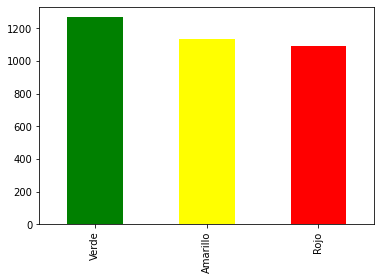

In [21]:
plt.rcParams['figure.figsize'] = [5, 5]
df_subterraneas['SEMAFORO'].value_counts().plot(kind='bar', color=['green', 'yellow', 'red'])

## <a id='2.2'>2.2. Distribucion de las features numericas</a> 

In [22]:
for col in metric_cols:
    print(col,'\n\nVerde:\n\n',df_subterraneas[df_subterraneas["SEMAFORO"]=="Verde"][col].describe(),'\n\nAmarillo:\n\n',df_subterraneas[df_subterraneas["SEMAFORO"]=="Amarillo"][col].describe(),'\n\nRojo:\n\n',df_subterraneas[df_subterraneas["SEMAFORO"]=="Rojo"][col].describe(),end='\n\n')

COLI_FEC_NMP_100mL 

Verde:

 count    544.000000
mean     281.205882
std      276.242590
min        3.000000
25%       41.000000
50%      210.000000
75%      430.000000
max      991.000000
Name: COLI_FEC_NMP_100mL, dtype: float64 

Amarillo:

 count      1100.000000
mean      12109.446364
std       25081.166681
min           3.000000
25%        1793.000000
50%        3873.000000
75%       24000.000000
max      241960.000000
Name: COLI_FEC_NMP_100mL, dtype: float64 

Rojo:

 count    9.380000e+02
mean     2.490353e+05
std      1.930221e+06
min      3.000000e+00
25%      4.300000e+02
50%      1.100000e+04
75%      2.400000e+04
max      2.419600e+07
Name: COLI_FEC_NMP_100mL, dtype: float64

E_COLI_NMP_100mL 

Verde:

 count    544.000000
mean      91.069853
std      135.977177
min        3.000000
25%        3.000000
50%       29.000000
75%      124.000000
max      750.000000
Name: E_COLI_NMP_100mL, dtype: float64 

Amarillo:

 count      1100.000000
mean       6901.537273
std       19801

Vemos que para cada metrica hay cambios en la media de acuerdo a su diagnostico de contaminacion.

Validar diferencias de cada feature con respecto a su valor en el semaforo

In [32]:
def function_map(metrica = "OD_PORC_FON"):
    sns.color_palette("husl", 9)
    sns.set_theme(style='whitegrid')
    plt.title(metrica)
    sns.kdeplot(x=df_subterraneas[metrica],hue = df_subterraneas['SEMAFORO'], palette={"Rojo":"red","Verde":"green","Amarillo":"yellow"} )
    plt.tight_layout()
    plt.show()

In [33]:
interact(function_map, metrica=metric_cols)

interactive(children=(Dropdown(description='metrica', index=4, options=('COLI_FEC_NMP_100mL', 'E_COLI_NMP_100m…

<function __main__.function_map(metrica='OD_PORC_FON')>

## <a id='2.3'>2.3. Matriz de correlacion</a>

<AxesSubplot:>

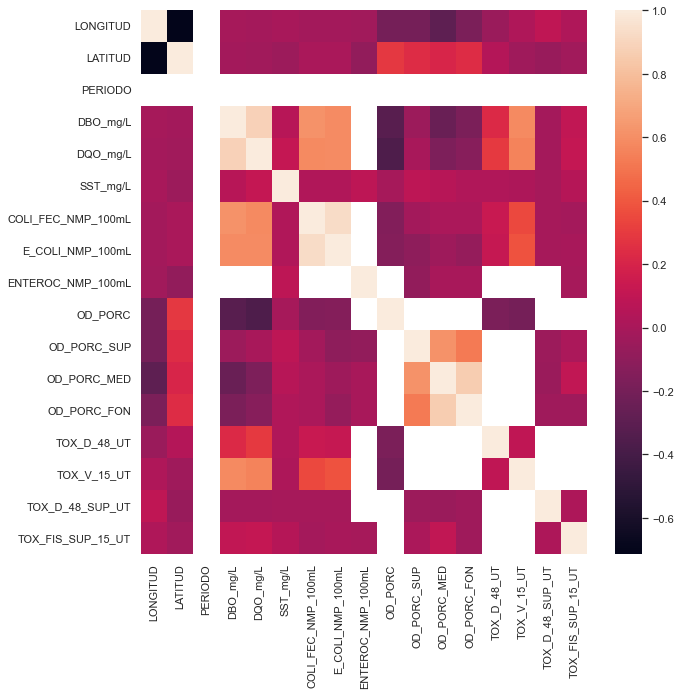

In [26]:
plt.rcParams['figure.figsize'] = [10, 10]
sns.heatmap(df_subterraneas.corr())


## <a id='2.4'>2.4. Identificar medidas de posición no centrales , los cuartiles , outliers. </a>  

In [96]:
def function_map(metrica='OD_PORC_FON'):

    fig,ax = plt.subplots(1,4,figsize=(20,5))
    
    sns.distplot(df_subterraneas[metrica],ax=ax[0],color='green')
    sns.boxplot(df_subterraneas[metrica],ax=ax[1],color='yellow')
    sns.violinplot(df_subterraneas[metrica],ax=ax[2],color='purple')
    stats.probplot(df_subterraneas[metrica],plot=ax[3])

    fig.tight_layout()
    fig.subplots_adjust(top=0.90)
    plt.suptitle("Visualiziando columnas continuas",fontsize=30)



In [97]:
interact(function_map, metrica=metric_cols)

interactive(children=(Dropdown(description='metrica', index=4, options=('COLI_FEC_NMP_100mL', 'E_COLI_NMP_100m…

<function __main__.function_map(metrica='OD_PORC_FON')>

# <a id='3'>3. Preparar los datos</a>

## <a href='#3.1'>3.1. Label encoding</a>

# <a id='4'>4. Mapa</a>

## <a id='4.1'>4.1. Graficar archivo KML</a>

In [28]:
supported_drivers['LIBKML'] = 'rw'

fiona.drvsupport.supported_drivers['KML'] = 'rw'

df = gpd.read_file('https://raw.githubusercontent.com/PosgradoMNA/actividades-del-projecto-grupo26/main/Reto/data/doc.kml', driver='LIBKML')

<AxesSubplot:>

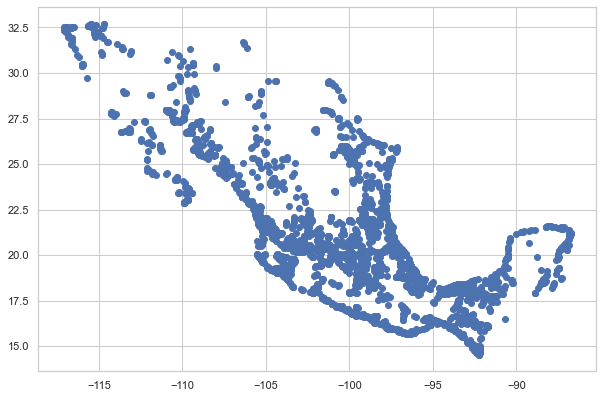

In [29]:
df.plot()

# <a id='5'>5. K- Means</a>

## <a id='5.1'>5.1. Realizar análisis para encontrar si existe una relación entre la calidad del agua y su ubicación geográfica a través de K- means.</a>

## <a id='5.2'>5.2. Mostrar resultados de agrupamiento de latitudes y longitudes con K means en el mapa de México.</a>